## GELU



一般的激活函数使用 ReLU，但其为分段函数，在 0 点处不可微。

$$
\text{ReLU}(x) = \max(0, x) = \frac{x+|x|}{2}
$$

GELU(Gaussian Error Linear Unit) 是 ReLU 的近似, 先看实现的效果。

In [2]:
import torch
import math

def ReLU(x):
    return (x + torch.abs(x)) * 0.5

def GELU(x):
    '''
    先不分析此代码, 近用于绘图展示 GELU 的激活曲线
    '''
    cdf = 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))
    return x * cdf

x = (torch.arange(200) - 100) / 10
y_relu = ReLU(x)
y_gelu = GELU(x)

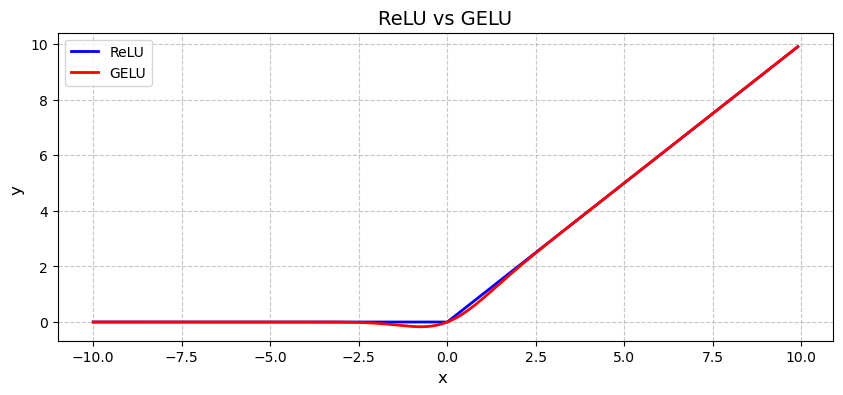

In [3]:
import matplotlib.pyplot as plt
import numpy as np

x_list = x.tolist()
y_relu_list = y_relu.tolist()
y_gelu_list = y_gelu.tolist()

# 创建图形和坐标轴
plt.figure(figsize=(10, 4))

# 绘制第一条曲线
plt.plot(x_list, y_relu_list, label='ReLU', color='blue', linewidth=2)

# 绘制第二条曲线
plt.plot(x_list, y_gelu_list, label='GELU', color='red', linewidth=2)

# 添加标题和标签
plt.title('ReLU vs GELU', fontsize=14)
plt.xlabel('x ', fontsize=12)
plt.ylabel('y ', fontsize=12)

# 添加图例
plt.legend()

# 添加网格
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.show()

## GELU 原理

1. 曲线在趋近 $ f(-\infty) \rightarrow 0 $ , $ f(\infty) \rightarrow 1 $
2. 定义 $gelu(x) = x \cdot g(x)$, 找到一个 $g(x)$ 有上述特性的函数

给定标准正态分布概率密度函数(pdf)：

$$
\phi(z) = \frac{1}{\sqrt{2\pi}} e^{-z^{2}/2}
$$

其**累积分布函数(cdf)**为

$$
\Phi(z) = P(Z \leq z) = \int_{-\infty}^{z} \phi(t) \, dt = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{z} e^{-t^{2}/2} \, dt
$$

其中，值域 $\Phi(z)\in [0,1]$, PDF 的积分即为 CDF


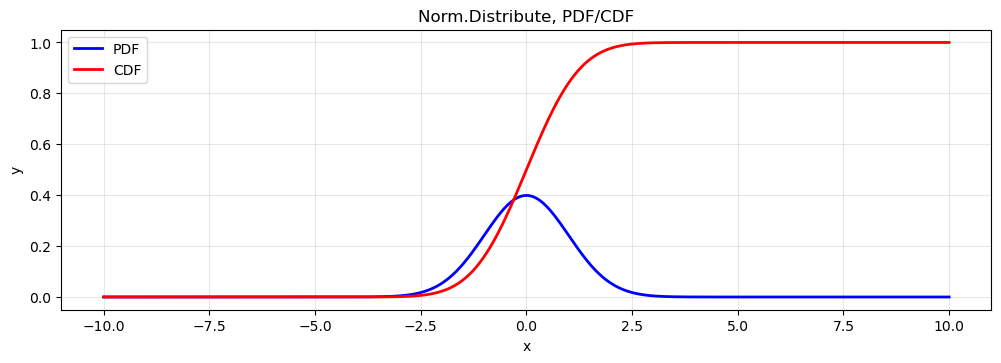

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erf
import math

mu = 0.0      # 均值
sigma = 1.0   # 标准差

plot_x = torch.linspace(-10, 10, 1000)
def gaussian_pdf(x, mu, sigma):
    return (1.0 / (sigma * math.sqrt(2 * math.pi))) * torch.exp(-0.5 * ((x - mu) / sigma) ** 2)

# 累积分布函数 (CDF) - 使用误差函数
def gaussian_cdf(x, mu, sigma):
    z = (x - mu) / (sigma * math.sqrt(torch.tensor(2.0)))
    return 0.5 * (1 + torch.erf(z))

pdf_values = gaussian_pdf(plot_x, mu, sigma)
cdf_values = gaussian_cdf(plot_x, mu, sigma)

# 创建图形
plt.figure(figsize=(12, 8))

# 绘制PDF
plt.subplot(2, 1, 1)
plt.plot(plot_x.numpy(), pdf_values.numpy(), 'b-', linewidth=2, label='PDF')
plt.plot(plot_x.numpy(), cdf_values.numpy(), 'r-', linewidth=2, label='CDF')
# plt.plot(x.numpy(), pdf_values_torch.numpy(), 'r--', linewidth=1, alpha=0.7, label='PDF (Torch Distribution)')
plt.title('Norm.Distribute, PDF/CDF')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True, alpha=0.3)
plt.legend()

plt.legend()

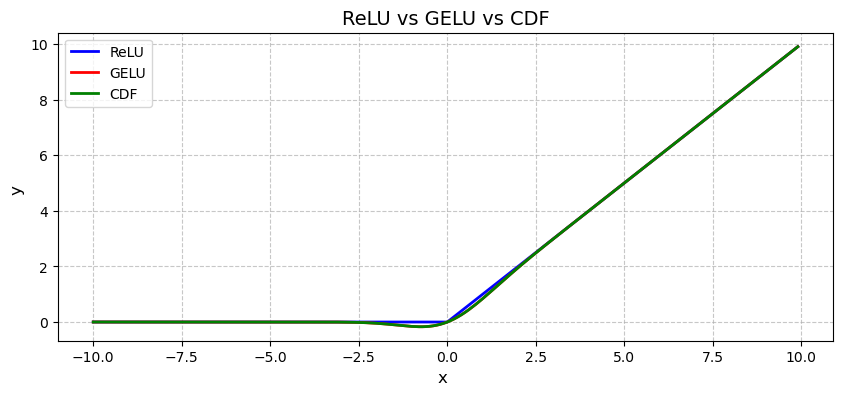

In [5]:
# def gaussian_pdf(x, mu, sigma):
#     return (1.0 / (sigma * math.sqrt(2 * math.pi))) * torch.exp(-0.5 * ((x - mu) / sigma) ** 2)

y_cdf = gaussian_cdf(x, mu, sigma)
# print(y_pdf)

import matplotlib.pyplot as plt
import numpy as np

x_list = x.tolist()
y_relu_list = y_relu.tolist()
y_gelu_list = y_gelu.tolist()
y_cdf_list = (x * y_cdf).tolist()

plt.figure(figsize=(10, 4))

plt.plot(x_list, y_relu_list, label='ReLU', color='blue', linewidth=2)
plt.plot(x_list, y_gelu_list, label='GELU', color='red', linewidth=2)
plt.plot(x_list, y_cdf_list, label='CDF', color='green', linewidth=2)

plt.title('ReLU vs GELU vs CDF', fontsize=14)
plt.xlabel('x ', fontsize=12)
plt.ylabel('y ', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

上述图像 GELU 与 CDF 重叠。

## CDF 求解

事实上， CDF 求解麻烦，需要离散 pdf 的步长。 erf（高斯误差函数） 有良好的数学性质，其已知的级数展开、渐近行为等，便于理论分析和推导。

erf公式为

$$
\operatorname{erf}(x) = \frac{2}{\sqrt{\pi}} \int_{0}^{x} e^{-t^{2}} \, dt
$$

cdf 为：

$$
\Phi(z) = P(Z \leq z) = \int_{-\infty}^{z} \phi(t) \, dt = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{z} e^{-t^{2}/2} \, dt
$$

令  $ u = t / \sqrt{2} $，则 $ t = u\sqrt{2} $，$ dt = \sqrt{2} \, du $, 代入 $ \Phi(z) $：

$$
\begin{align}
\Phi(z) &= \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{z} e^{-t^{2}/2} \, dt = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{z/\sqrt{2}} e^{-u^{2}} \cdot \sqrt{2} \, du \\
&=  \frac{1}{\sqrt{\pi}} \int_{-\infty}^{z/\sqrt{2}} e^{-u^{2}} \, du
\end{align}
$$

现在，我们将这个积分拆分成两部分（从 $-\infty$ 到 0，以及从 0 到 $z/\sqrt{2}$）：
$$
\Phi(z) = \frac{1}{\sqrt{\pi}} \left[ \int_{-\infty}^{0} e^{-u^{2}} \, du + \int_{0}^{z/\sqrt{2}} e^{-u^{2}} \, du \right]
$$

我们知道 $ \int_{-\infty}^{0} e^{-u^{2}} \, du = \frac{\sqrt{\pi}}{2} $，并且根据定义，第二个积分是 $ \frac{\sqrt{\pi}}{2} \operatorname{erf}(z/\sqrt{2}) $。

因此：
$$
\Phi(z) = \frac{1}{\sqrt{\pi}} \left[ \frac{\sqrt{\pi}}{2} + \frac{\sqrt{\pi}}{2} \operatorname{erf}\left(\frac{z}{\sqrt{2}}\right) \right ]
$$

$$
\Phi(z) = \frac{1}{2} \left[ 1 + \operatorname{erf}\left(\frac{z}{\sqrt{2}}\right) \right ]
$$

 

In [6]:
def GELU(x):
    cdf = 0.5 * (1.0 + torch.erf(x / torch.sqrt(2.0)))
    return x * cdf

## 近似

In [11]:
def GELU_approx_1(x):
    cdf = 0.5 * (1.0 + torch.tanh( math.sqrt(2.0 / torch.pi) * (x + 0.044715 * torch.pow(x, 3))))
    return x * cdf

In [12]:
def GELU_approx_2(x):
    cdf = torch.sigmoid(1.702 * x)
    return x * cdf

In [13]:
approx_1 = GELU_approx_1(x)
approx_2 = GELU_approx_2(x)

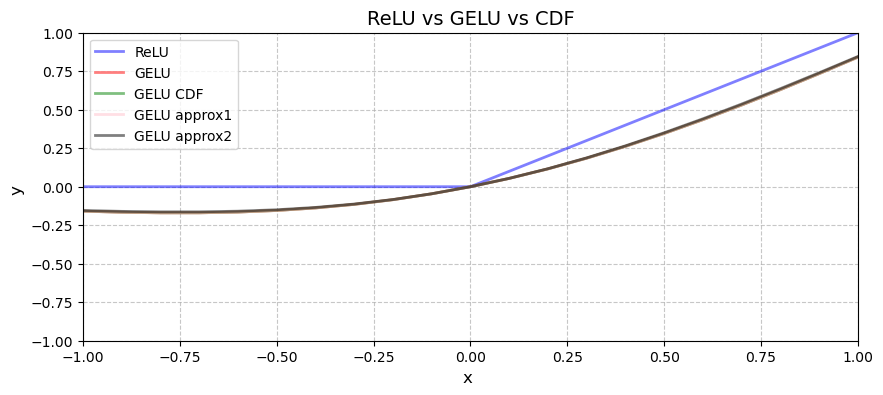

In [18]:

y_cdf = gaussian_cdf(x, mu, sigma)

x_list = x.tolist()
y_relu_list = y_relu.tolist()
y_gelu_list = y_gelu.tolist()
y_cdf_list = (x * y_cdf).tolist()
y_approx_1_list = approx_1.tolist()
y_approx_2_list = approx_2.tolist()

plt.figure(figsize=(10, 4))

plt.plot(x_list, y_relu_list, label='ReLU', color='blue', linewidth=1, alpha = 0.5)
plt.plot(x_list, y_gelu_list, label='GELU', color='red', linewidth=1, alpha = 0.5)
plt.plot(x_list, y_cdf_list, label='GELU CDF', color='green', linewidth=1, alpha = 0.5)
plt.plot(x_list, y_approx_1_list, label='GELU approx1', color='pink', linewidth=1, alpha = 0.5)
plt.plot(x_list, y_approx_2_list, label='GELU approx2', color='black', linewidth=2, alpha = 0.5)

plt.title('ReLU vs GELU vs CDF', fontsize=14)
plt.xlabel('x ', fontsize=12)
plt.ylabel('y ', fontsize=12)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Reference

[GELU](https://alaaalatif.github.io/2019-04-11-gelu/)